# American Sign Language - MobileNetV3 Large

Author: [Sayan Nath](https://github.com/sayannath)

Dataset Link: [Kaggle ASL](https://www.kaggle.com/grassknoted/asl-alphabet)

## Initial Setup

In [ ]:
!nvidia-smi

Sun Mar 28 10:51:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install kaggle
!pip install -q tensorflow-addons

     |████████████████████████████████| 706kB 8.6MB/s 


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayannath2350","key":"a06037980919686feec73218553a329e"}'}

## Data Gathering

In [ ]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d grassknoted/asl-alphabet
!unzip -q asl-alphabet.zip

 99% 1.02G/1.03G [00:12<00:00, 82.2MB/s]
100% 1.03G/1.03G [00:12<00:00, 90.4MB/s]


In [ ]:
mkdir train

In [ ]:
import shutil
shutil.make_archive('dataset', 'zip', '/content/asl_alphabet_train/asl_alphabet_train')

'/content/dataset.zip'

In [ ]:
!pip install patool

import patoolib
patoolib.extract_archive("dataset.zip", outdir="train/")

     |████████████████████████████████| 81kB 4.3MB/s 
patool: Extracting dataset.zip ...
patool: running /usr/bin/7z x -otrain/ -- dataset.zip
patool: ... dataset.zip extracted to `train/'.


'train/'

## Setting up Path

In [ ]:
train_dir = 'train/'

## Import the modules

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

print(tf.__version__)

2.4.1


In [ ]:
from imutils import paths
from pprint import pprint
from collections import Counter
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import re 

import os
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns

import numpy as np
np.random.seed(42)

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## Determine the dimension of the images

In [ ]:
dim1 = []
dim2 = []
for image_filename in os.listdir(train_dir+'A'):
    
    img = mpimg.imread(train_dir+'A'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


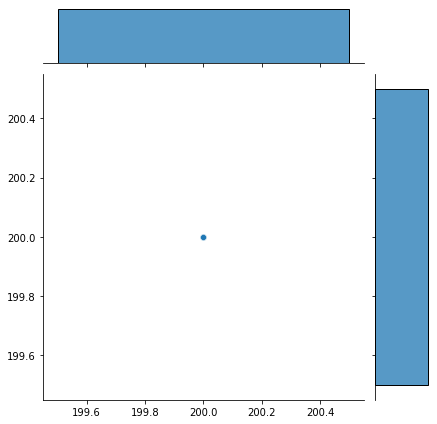

In [ ]:
sns.jointplot(dim1,dim2)

In [ ]:
print(np.mean(dim1))
print(np.mean(dim2))

200.0
200.0


`Height` is 200 and `Width` is 200

In [ ]:
image_paths = list(paths.list_images("train"))
np.random.shuffle(image_paths)
image_paths[:5]

['train/R/R1803.jpg',
 'train/T/T920.jpg',
 'train/space/space335.jpg',
 'train/L/L2548.jpg',
 'train/A/A1783.jpg']

## Counting number of images per class

In [ ]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count)

Counter({'R': 3000,
         'T': 3000,
         'space': 3000,
         'L': 3000,
         'A': 3000,
         'O': 3000,
         'Y': 3000,
         'Z': 3000,
         'Q': 3000,
         'E': 3000,
         'V': 3000,
         'U': 3000,
         'G': 3000,
         'B': 3000,
         'M': 3000,
         'X': 3000,
         'del': 3000,
         'P': 3000,
         'H': 3000,
         'C': 3000,
         'N': 3000,
         'D': 3000,
         'W': 3000,
         'I': 3000,
         'J': 3000,
         'K': 3000,
         'F': 3000,
         'nothing': 3000,
         'S': 3000})


Wow! Balanced Dataset

## Define the Hyperparamteres

In [ ]:
TRAIN_SPLIT = 0.9
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
EPOCHS = 100
IMG_SIZE = 224
NUM_CLASSES=29

## Splitting the dataset

In [ ]:
i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

78300 8700


## Labelling the dataset

In [ ]:
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
validation_labels_le = le.transform(validation_labels)
print(train_labels_le[:5])

[17 19 28 11  0]


## Preprocessing the data

In [ ]:
@tf.function
def load_images(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    # No rescaling since MobileNetV3 internally does it
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return (image, label)

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

## Creating the `Data` Pipeline

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))

train_ds = (
    train_ds
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))
val_ds = (
    val_ds
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Define the Model

In [ ]:
def get_training_model(trainable=False):
    # Load the MobileNetV3 model but exclude the classification layers
    EXTRACTOR = MobileNetV3Large(weights="imagenet", include_top=False,
                    input_shape=(224, 224, 3))
    # We will set it to both True and False
    EXTRACTOR.trainable = trainable
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(NUM_CLASSES, activation="softmax", dtype="float32")(class_head)

    # Create the new model
    classifier = tf.keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="sparse_categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

## Plot

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_accuracy", "val_accuracy", "train_loss", "val_loss"], loc="upper left")
    plt.show()

## Define the Callback

In [ ]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, restore_best_weights=True)
]

## Train the Model

17612800/17605208 [==============================] - 0s 0us/step
Epoch 1/100
306/306 [==============================] - 1206s 4s/step - loss: 2.0295 - accuracy: 0.4414 - val_loss: 0.2950 - val_accuracy: 0.9280
Epoch 2/100
306/306 [==============================] - 1117s 4s/step - loss: 0.4953 - accuracy: 0.8502 - val_loss: 0.1705 - val_accuracy: 0.9501
Epoch 3/100
306/306 [==============================] - 1266s 4s/step - loss: 0.3424 - accuracy: 0.8928 - val_loss: 0.1298 - val_accuracy: 0.9601
Epoch 4/100
306/306 [==============================] - 1050s 3s/step - loss: 0.2725 - accuracy: 0.9133 - val_loss: 0.0995 - val_accuracy: 0.9680
Epoch 5/100
306/306 [==============================] - 1040s 3s/step - loss: 0.2351 - accuracy: 0.9248 - val_loss: 0.0919 - val_accuracy: 0.9713
Epoch 6/100
306/306 [==============================] - 1077s 3s/step - loss: 0.2228 - accuracy: 0.9270 - val_loss: 0.0831 - val_accuracy: 0.9728
Epoch 7/100
306/306 [==============================] - 1067s 3s/s

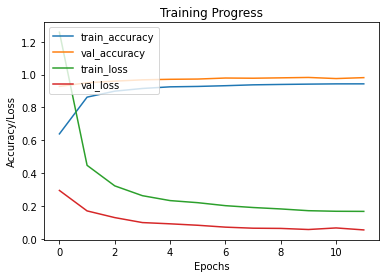

In [ ]:
classifier = get_training_model()
h = classifier.fit(train_ds,
               validation_data=val_ds,
               epochs=EPOCHS,
               batch_size=BATCH_SIZE,
               callbacks=train_callbacks)

accuracy = classifier.evaluate(val_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

plot_hist(h)

## Saving our model

In [ ]:
classifier.save('asl_model')

INFO:tensorflow:Assets written to: asl_model/assets


In [ ]:
!du -lh asl_model

24M	asl_model/variables
4.0K	asl_model/assets
29M	asl_model


## Saving the h5 file

In [ ]:
KERAS_ASL_FILE = 'asl.h5'
classifier.save(KERAS_ASL_FILE)

## Helper Function - To determine the file size of our model

In [ ]:
import os
from sys import getsizeof

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File Size: ' + str(round(size/1024, 3)) + 'Kilobytes')
    elif unit == 'MB':
        return print('File Size: ' + str(round(size/(1024*1024), 3)) + 'Megabytes')
    else:
        return print('File Size: ' + str(size) + 'bytes')

In [ ]:
convert_bytes(get_file_size(KERAS_ASL_FILE), "MB")

File Size: 24.606Megabytes


Wow! 24MB

## Zipping our model together

In [ ]:
!tar cvf asl_model.tar.gz asl_model asl.h5

asl_model/
asl_model/saved_model.pb
asl_model/variables/
asl_model/variables/variables.index
asl_model/variables/variables.data-00000-of-00001
asl_model/assets/
asl.h5


# Step 2 - Convert our saved model to TF-Lite

Notebook Link: